<a href="https://colab.research.google.com/github/sammwaughh/Deep-Learning/blob/main/convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main imports**

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
batch_size=16, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
batch_size=16, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

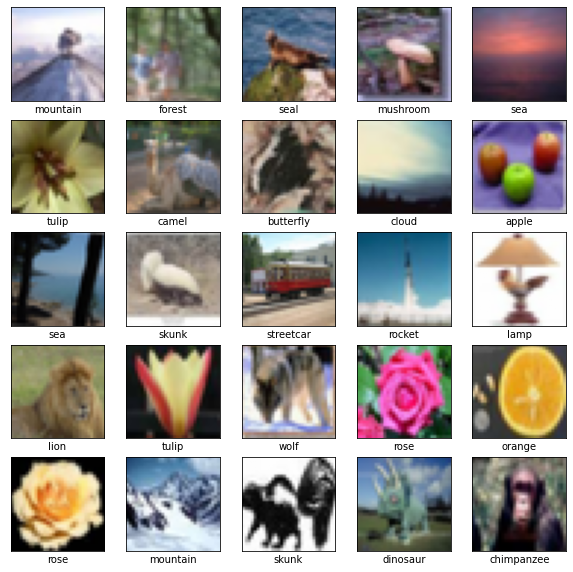

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define a simple model**

In [ ]:
# define the model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(128, 100, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.AvgPool2d((4,4)))
        self.layers = layers

    def forward(self, x):
        for m in self.layers:
            x = m(x)
        return x

N = ConvolutionalNetwork().to(device)

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0

> Number of network parameters 339328


**Main training and testing loop**

In [ ]:
while (epoch<5):

    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x).view(x.size(0), len(class_names))
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # iterate entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x).view(x.size(0), len(class_names))
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    print('train loss: {:.3f}, train acc: {:.3f}, test acc: {:.3f}'.format(
        train_loss_arr.mean(),train_acc_arr.mean(),test_acc_arr.mean()))

    epoch = epoch+1

train loss: 4.053, train acc: 0.087, test acc: 0.141
train loss: 3.553, train acc: 0.161, test acc: 0.198
train loss: 3.296, train acc: 0.210, test acc: 0.234
train loss: 3.166, train acc: 0.239, test acc: 0.250
train loss: 3.011, train acc: 0.262, test acc: 0.266


**Inference on dataset**

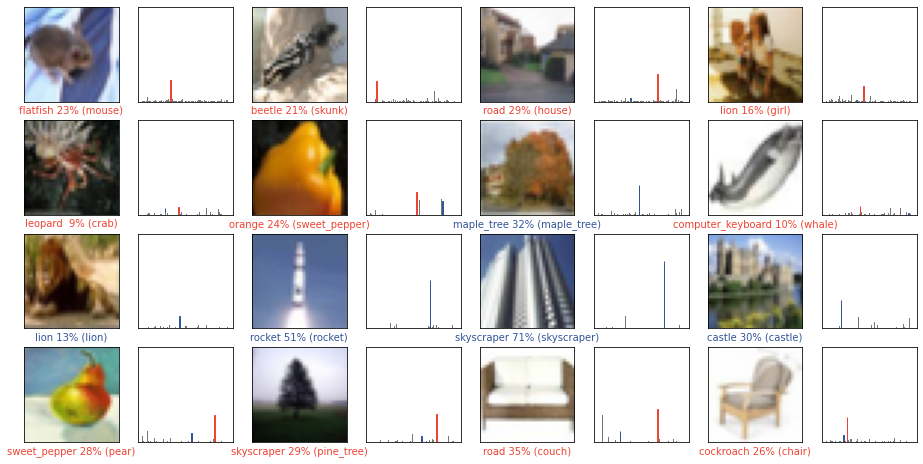

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images).view(test_images.size(0), len(class_names)), dim=1).data.squeeze().cpu().numpy()

num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu(), test_images.cpu().squeeze().permute(1,3,2,0).contiguous().permute(3,2,1,0))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels)